In [15]:

import glob
import os
import shutil
import cv2

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from pipeline.python.utils import convert_range


In [2]:
%matplotlib notebook

In [3]:
import matplotlib.ticker as ticker

def format_ticks(x):
    return '%.1f' % round(x, 2)

# set output dir

In [4]:
outdir = os.path.join('/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps', 'figures')
if not os.path.exists(outdir):
    os.makedirs(outdir)


# Select dataset

In [10]:
animalid = 'JC084'
session = '20190517'
#session = '20190522'
#fov = 'FOV1_zoom2p0x'
#retinorun = 'retino_run2'


# Widefield

In [11]:
screen_x = 119.5564
screen_y = 67.323
resolution = [1024, 768]


In [12]:
surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'

analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [13]:
glob.glob(os.path.join(surface_basedir, animalid, session))

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517']

In [16]:
surface_path = glob.glob(os.path.join(surface_basedir, animalid, session, 'Surface', '*.png'))[0]
surf = cv2.imread(surface_path, -1)
surf.shape

(164, 218)

<IPython.core.display.Javascript object>


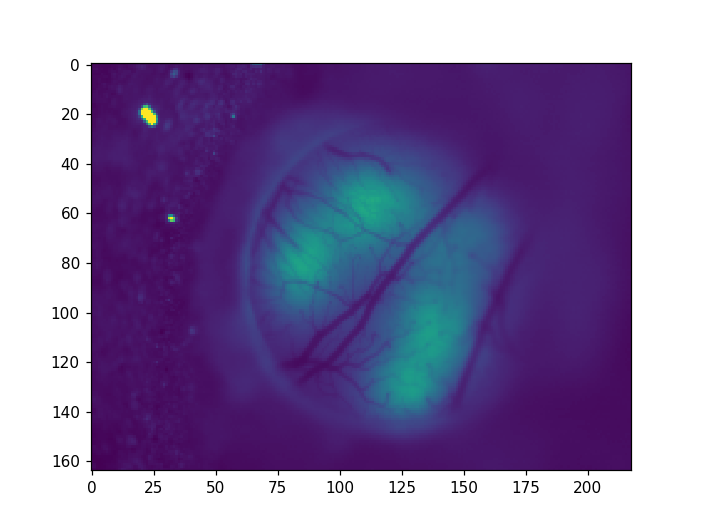

In [17]:
pl.figure()
pl.imshow(surf)

In [20]:

#animalid = 'JC085'
#session = '20190620'

datapaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'Files', '*.npz'))


In [21]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
print mappaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190517_cond2_maps.npz', '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190517_cond3_maps.npz']


In [22]:
datapaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond2.0_averageTimeCourse.npz',
 '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond3.0_averageTimeCourse.npz']

In [53]:
skey = '-'.join([animalid, session])


# Load data

In [23]:

data = np.load(datapaths[0])
data.keys()

['groupPeriods',
 'meanPixelValue',
 'frameArrayAvg',
 'szX',
 'szY',
 'frameArrayGroupedAvg',
 'frameTimes',
 'frameCount']

In [24]:

d1, d2 = data['szX'], data['szY']


In [25]:
_, nframes = data['frameArrayAvg'].shape
farray = data['frameArrayAvg'] #np.reshape(data['frameArrayAvg'],  (d2, d1, nframes))
print(farray.shape)

(35752, 1922)


In [26]:
meanpix = data['meanPixelValue']
meanpix.shape

(35752,)

In [27]:
np.expand_dims(meanpix,1).shape

(35752, 1)

In [28]:
meanpix = np.expand_dims(meanpix,1)
meanpix_array = np.tile(meanpix, (1, farray.shape[1]))


In [29]:
dff_array = np.true_divide(farray, meanpix_array)
dff_array.shape

(35752, 1922)

In [30]:
dff_img = np.reshape(dff_array, (d2, d1, nframes)).max(axis=-1)
dff_img.shape

(164, 218)

<IPython.core.display.Javascript object>


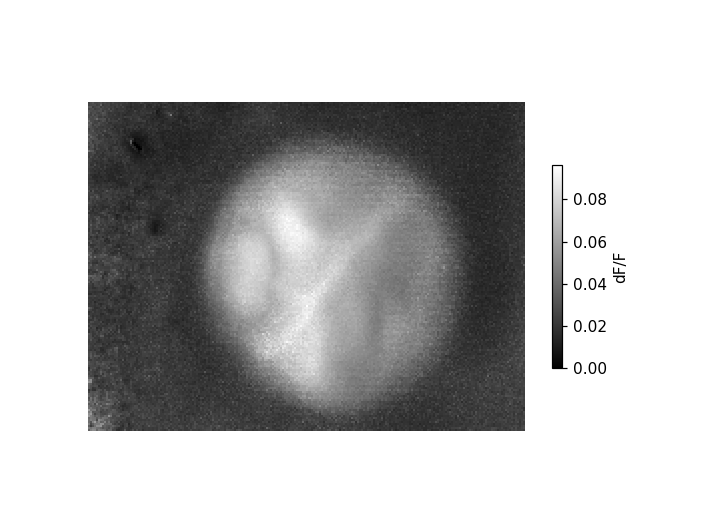

(-0.5, 217.5, 163.5, -0.5)

In [31]:

fig, ax = pl.subplots()
im = ax.imshow(dff_img, cmap='gray')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size='2%', pad=0.1, shrink=.5)
fig.colorbar(im, label='dF/F', shrink=0.5, pad=0.05)
ax.axis('off')

In [16]:

_, nframes_grouped = data['frameArrayGroupedAvg'].shape

farray_grouped = data['frameArrayGroupedAvg']#  np.reshape(data['frameArrayGroupedAvg'], (d2, d1, nframes))


In [32]:
meanpix.shape

(35752, 1)

In [33]:
nperiods_group = data['groupPeriods']
meanpix_grouped = np.tile(meanpix, (1, farray_grouped.shape[1]))
meanpix_grouped.shape


NameError: name 'farray_grouped' is not defined

In [34]:
dff_array_grouped = np.true_divide(farray_grouped, meanpix_grouped)
dff_array_grouped.shape



NameError: name 'farray_grouped' is not defined

In [20]:
dff_img_grouped = np.reshape(dff_array_grouped, (d2, d1, nframes_grouped)).max(axis=-1)
dff_img_grouped.shape

(164, 218)

<IPython.core.display.Javascript object>


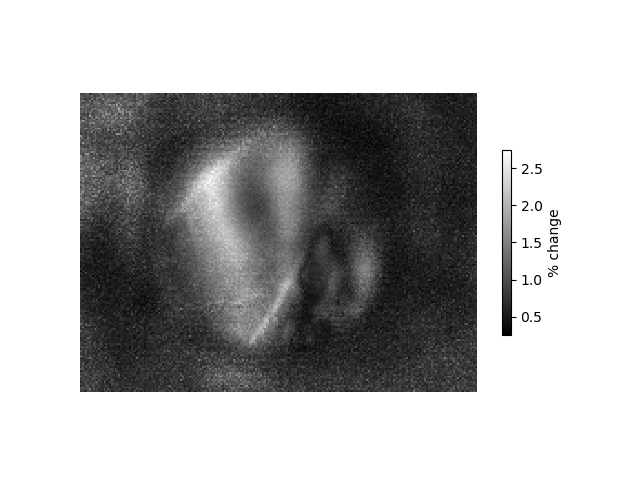

cond2-grouped-dff-image_JC085-20190620


In [175]:

fig, ax = pl.subplots()
im = ax.imshow(dff_img_grouped*100, cmap='gray')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size='2%', pad=0.1, shrink=.5)
fig.colorbar(im, label='% change', shrink=0.5, pad=0.05, format='%.1f')
ax.axis('off')
figname = 'cond2-grouped-dff-image_%s' % skey
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

In [26]:
dff = np.reshape(dff_array_grouped, (d2, d1, nframes_grouped))
print dff.shape

(164, 218, 383)


In [69]:
vmin, vmax = dff.min(), dff.max()
print vmin, vmax

-0.021479432411640555 0.02747004825765947


In [ ]:
pos_x = convert_range(pmin, newmin=0, newmax=screen_x, oldmin=0, oldmax=pmax)


In [338]:
screen_x

119.5564

<IPython.core.display.Javascript object>


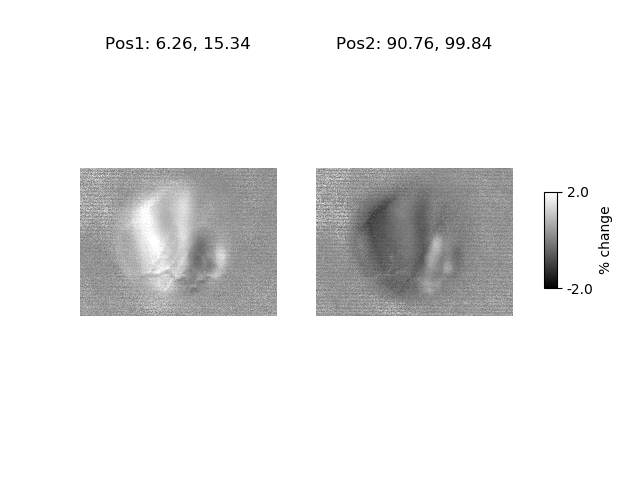

cond2-grouped-dff-binned-pos_gray_JC085-20190620


In [293]:
binsize=30
cmap = 'gray' #'PRGn'
vmax = 0.02 * 100
vmin = -0.02 * 100

s_ix1 = 20
s_ix2 = 290
s_ix3 = 280

degpos = np.linspace(0, screen_x, dff.shape[-1])
pos1_deg = degpos[s_ix1:s_ix1+binsize]
pos2_deg = degpos[s_ix2:s_ix2+binsize]
pos3_deg = degpos[s_ix3:s_ix3+binsize]

ixs1 = np.arange(s_ix1, s_ix1+binsize)
ixs2 = np.arange(s_ix2, s_ix2+binsize)
ixs3 = np.arange(s_ix3, s_ix3+binsize)

fig, axes = pl.subplots(1,2, sharex=True, sharey=True)
im= axes[0].imshow(dff[:, :, ixs1].max(axis=-1) * 100 , cmap=cmap, vmin=vmin, vmax=vmax)
im = axes[1].imshow(dff[:, :, ixs2].max(axis=-1) * 100, cmap=cmap, vmin=vmin, vmax=vmax)

for ax in axes:
    ax.axis('off')
    

axes[0].set_title("Pos1: %.2f, %.2f" % (pos1_deg[0], pos1_deg[-1]))
axes[1].set_title("Pos2: %.2f, %.2f" % (pos2_deg[0], pos2_deg[-1]))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))


fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmax], label='% change')
cbar_ax.set_yticklabels([vmin, vmax])

#cbar_ax.set_yticks([cbar_ax.get_ylim()[0], cbar_ax.get_ylim()[-1]])
#cbar_ax.set_yticks([cbar_ax.get_ylim()[0], cbar_ax.get_ylim()[-1]])
figname = 'cond2-grouped-dff-binned-pos_%s_%s' % (cmap, skey)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Legends

In [35]:
deg_per_pixel = screen_x / float(resolution[0])


In [36]:
x = np.linspace(0, 2*np.pi, int(round(screen_x)))
y = np.linspace(0, 2*np.pi, int(round(screen_y)) )

xv, yv = np.meshgrid(x, y)


az_legend = (2*np.pi) - xv
el_legend = yv


In [37]:
# def convert_boundary(boundary_pix, center_deg ,deg_per_pixel):

#     boundary_deg = boundary_pix * deg_per_pixel
#     boundary_relative_deg = boundary_deg - center_deg
    
#     return boundary_relative_deg

In [38]:
az_screen = convert_range(az_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)
el_screen = convert_range(el_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)


In [39]:
az_screen.shape

(67, 120)

<IPython.core.display.Javascript object>


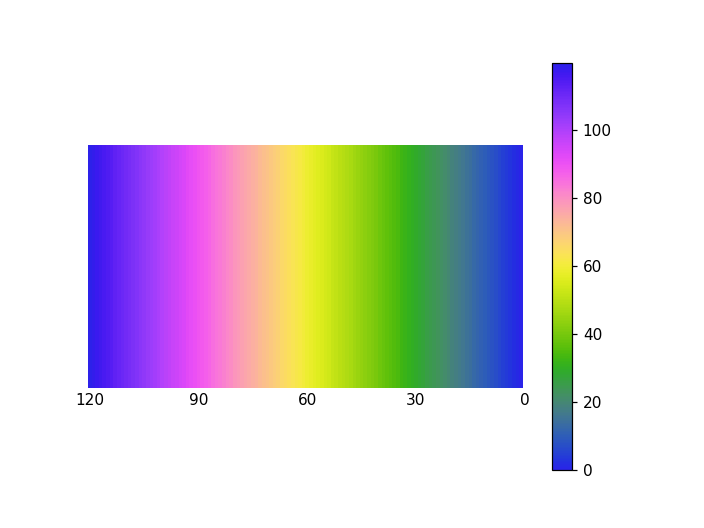

cond2-grouped-dff-binned-pos_colorwheel_JC084-20190517_LEGEND_to2p


In [70]:
fig, ax = pl.subplots()
im = ax.imshow(az_screen, cmap=cmap_phase)
#ax.invert_xaxis()
pl.colorbar(im)
ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

#spos1, epos1 = pos1_deg[0], pos1_deg[-1]
#spos2, epos2 = pos2_deg[0], pos2_deg[-1]

#ax.axvline(x=screen_x-spos1, c='w')
#ax.axvline(x=screen_x-epos1, c='w')

#ax.axvline(x=screen_x-spos2, c='w')
#ax.axvline(x=screen_x-epos2, c='w')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', length=0)
ax.set_frame_on(False)
#ax.set_xlim(ax.get_xlim()[::-1])


figname = 'cond2-grouped-dff-binned-pos_%s_%s_LEGEND_to2p' % (colormap, skey)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Recolor maps

In [40]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


In [41]:


def get_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True):
    phase_az = mapdata['phaseMap'].copy()
    mag_az = mapdata['magRatioMap'].copy()

    if smooth_fwhm is not None:
        phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
        mag_az = smooth_array(mag_az, smooth_fwhm)

    if recenter:
        phaseC_az=np.copy(phase_az)
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        phasemin = 0
        phasemax = 2*np.pi
    else:
        phaseC_az = np.copy(phase_az)
        phasemin = -np.pi
        phasemax = np.pi


    phaseC_az[mag_az<mag_thr]=np.nan
    
    return phaseC_az, mag_az, phasemin, phasemax



# Select colormap

In [57]:
# Load colormap
colormap = 'colorwheel'
cmapdir = '/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

    

# Load maps

In [58]:
print os.path.split(mappaths[0])[-1]
mapdata_az = np.load(mappaths[0])
mapdata_az.keys()
mapdata_el = np.load(mappaths[1])

20190517_cond2_maps.npz


In [63]:
smooth_fwhm = 7
recenter = True
mag_thr = 0.02

phase_az, mag_az, pmin, pmax = get_maps(mapdata_az, smooth_fwhm=smooth_fwhm, mag_thr=mag_thr, recenter=recenter)
phase_el, mag_el, pmin, pmax = get_maps(mapdata_el, smooth_fwhm=smooth_fwhm, mag_thr=mag_thr, recenter=recenter)

        

In [64]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/figures'

<IPython.core.display.Javascript object>


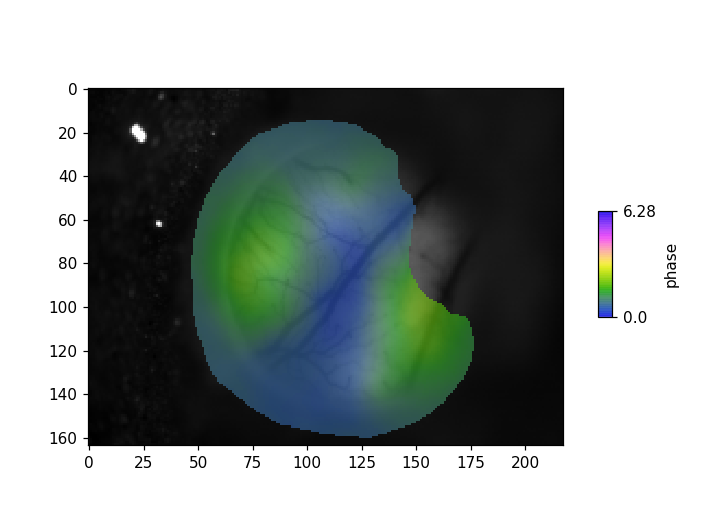

azimuth-phasemap_colorwheel_JC084-20190517


In [65]:



fig, ax = pl.subplots()
ax.imshow(surf, cmap='gray')
im = ax.imshow(phase_az, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
cbar_ax.set_yticklabels([round(pmin, 2), round(pmax,2)])

figname = 'azimuth-phasemap_%s_%s' % (colormap, skey)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

<IPython.core.display.Javascript object>


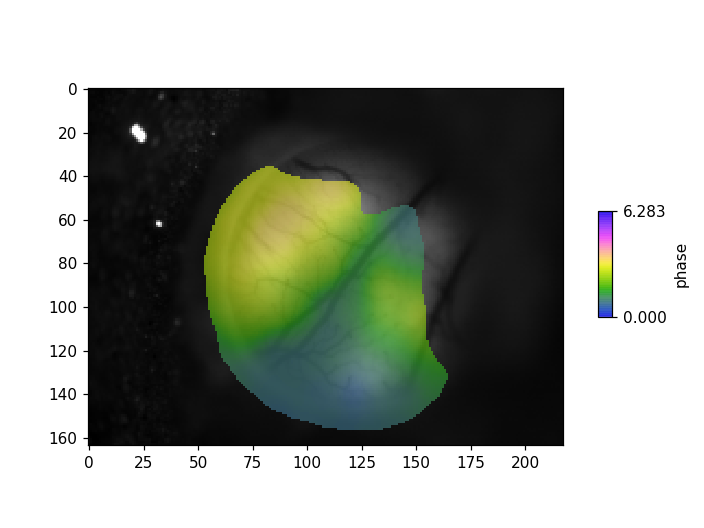

elevation-phasemap_colorwheel_JC084-20190517


In [66]:
fig, ax = pl.subplots()
ax.imshow(surf, cmap='gray')
im = ax.imshow(phase_el, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
#cbar_ax.set_yticklabels([round(pmax, 2), round(pmin,2)])

figname = 'elevation-phasemap_%s_%s' % (colormap, skey)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

In [67]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/figures'

<IPython.core.display.Javascript object>


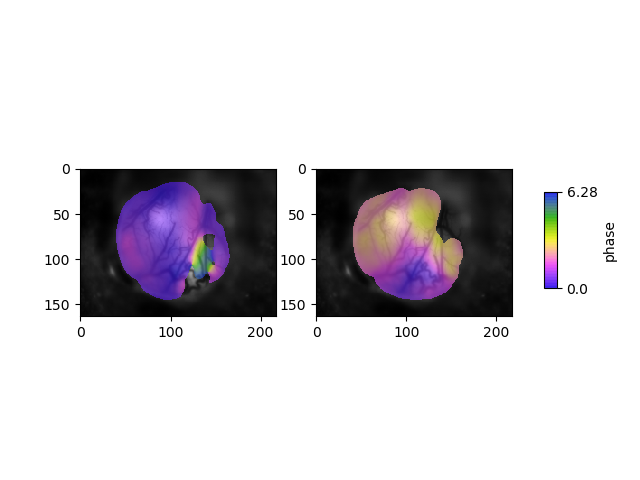

[Text(1,0,u'0.0'), Text(1,0,u'6.28')]

In [290]:
#### plot



fig, axes = pl.subplots(1, 2)
axes[0].imshow(surf, cmap='gray')
axes[1].imshow(surf, cmap='gray')
im = axes[0].imshow(phase_az, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)
im = axes[1].imshow(phase_el, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
cbar_ax.set_yticklabels([round(pmin, 2), round(pmax,2)])

pl.savefig(os.path.join())

# 2p

In [14]:
import cPickle as pkl
import h5py

In [18]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session2p = '20190522'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run2'

avgtraces_path = glob.glob(os.path.join(rootdir, animalid, session2p, fov, retinorun, 'retino_analysis', 
                                  'analysis*', 'traces', 'averaged_roi_traces.pkl'))[0]
retinodir = avgtraces_path.split('/traces/')[0]
print(retinodir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a


In [19]:
with open(avgtraces_path, 'rb') as f:
    avgtraces = pkl.load(f)

In [20]:
avgtraces.keys()

['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions']

In [21]:
trials_by_cond = avgtraces['conditions']
trials_by_cond

{u'bottom': [3, 5, 9],
 u'left': [11, 1, 4],
 u'right': [12, 2, 8],
 u'top': [10, 7, 6]}

In [37]:
retino_dpath = os.path.join(os.path.split(avgtraces_path)[0], 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')
tfile.keys()

[u'File001',
 u'File002',
 u'File003',
 u'File004',
 u'File005',
 u'File006',
 u'File007',
 u'File008',
 u'File009',
 u'File010',
 u'File011',
 u'File012']

# Visualize 1 condition 

In [25]:
currcond = 'right'

In [26]:
stiminfo = avgtraces['traces'][currcond]['info']
stiminfo

{'frame_rate': 44.6528, 'n_reps': 3, 'stimfreq': 0.24, 'stimulus': u'right'}

In [27]:
fr = float(stiminfo['frame_rate'])
n_frames = float(avgtraces['traces'][currcond]['traces'].shape[-1])
stim_freq = float(stiminfo['stimfreq'])
stimperiod = 1./stim_freq

n_cycles = int(round((n_frames/fr) / stimperiod))
n_frames_per_cycle = int(np.floor(stimperiod * fr))

cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

In [28]:
cycle_starts

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1860,
       2046])

#### average traces

In [30]:
xticks = np.linspace(0, n_frames, 5)
xticklabels = [round(float(f)/fr) for f in xticks]


In [31]:
rois_plot = [57, 175, 247]
colors = ['royalblue', 'darkorange', 'forestgreen']

<IPython.core.display.Javascript object>


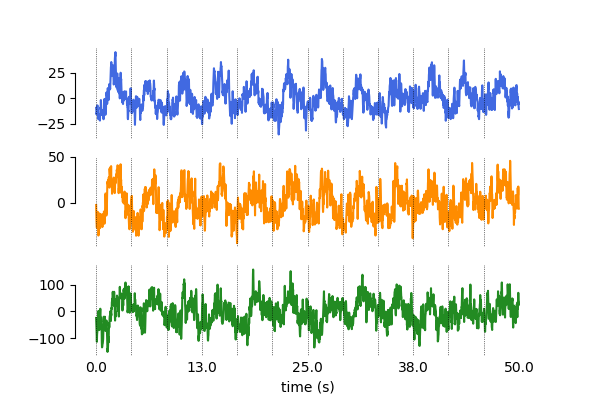

Text(0.5,0,u'time (s)')

In [36]:
fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, roi) in enumerate(zip(axes, rois_plot)):
    meanval = avgtraces['traces']['right']['traces'][roi, :].mean()
    ax.plot( (avgtraces['traces']['right']['traces'][roi, :]-meanval) / meanval , color=colors[ri])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
        
ax.set_xlabel('time (s)')

#figname = 'example-traces_cond-%s_%s' % (currcond, skey)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print figname

# Reprocess with raw traces

In [38]:
trials_by_cond

{u'bottom': [3, 5, 9],
 u'left': [11, 1, 4],
 u'right': [12, 2, 8],
 u'top': [10, 7, 6]}

In [39]:
currcond = 'right'

In [40]:
tfile['File001'].keys()

[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']

# Do FFT

In [ ]:
# label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1/fr))
idx = np.argsort(freqs)
freqs=freqs[idx]
print(freqs)

# exclude DC offset from data
freqs=freqs[int(np.round(n_frames/2.))+1:]

# Identify freq idx:
freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
print("Target freq: %.3f Hz" % freqs[freq_idx])
#max_mod_idx=np.argmax(magnitudes[freq_idx, :],0)#best pixel index
